In [1]:
from os.path import join
import pandas as pd
from stepmix import StepMix
from matplotlib import pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sys import path
path.insert(0, '..')
from utils import format_decision_tree_plot

In [2]:
onet_skills = pd.read_csv(join('..', 'onet_skills_unstacked.csv'), index_col=['O*NET-SOC Code', 'Title'])

In [3]:
SAVE_FIGURES = True
PRINT_OUTPUT = True
SEED = 42

# Finding Ideal Number of Components In Mixture Model

In [4]:
aic = []
bic = []
range_components_trying = range(2, 20)
for i in range_components_trying:
    gmm = StepMix(
        n_components = i,
        measurement = 'continuous',
        init_params = 'random',
        random_state = SEED,
        progress_bar = 1 if PRINT_OUTPUT else 0
    ).fit(
        X=onet_skills.values
    )
    aic.append(gmm.aic(onet_skills.values))
    bic.append(gmm.bic(onet_skills.values))

Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:00<00:00, 123.95it/s, max_LL=-2.79e+4, max_avg_LL=-31.9]


Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:00<00:00, 78.31it/s, max_LL=-2.55e+4, max_avg_LL=-29.2]


Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:00<00:00, 34.46it/s, max_LL=-1.85e+4, max_avg_LL=-21.2]


Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:00<00:00, 78.75it/s, max_LL=-1.71e+4, max_avg_LL=-19.6]


Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:00<00:00, 29.68it/s, max_LL=-1.59e+4, max_avg_LL=-18.2]


Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:00<00:00, 32.62it/s, max_LL=-1.51e+4, max_avg_LL=-17.3]


Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:00<00:00, 60.55it/s, max_LL=-1.34e+4, max_avg_LL=-15.4]


Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:00<00:00,  1.81it/s, max_LL=-1.35e+4, max_avg_LL=-15.5]


Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:00<00:00,  1.63it/s, max_LL=-1.25e+4, max_avg_LL=-14.3]


Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:00<00:00,  1.06it/s, max_LL=-1.25e+4, max_avg_LL=-14.3]


Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:01<00:00,  1.35s/it, max_LL=-1.19e+4, max_avg_LL=-13.6]


Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:00<00:00,  1.73it/s, max_LL=-1.12e+4, max_avg_LL=-12.8]


Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:00<00:00,  1.15it/s, max_LL=-1.1e+4, max_avg_LL=-12.6]


Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:00<00:00,  1.06it/s, max_LL=-1.03e+4, max_avg_LL=-11.8]


Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:01<00:00,  1.86s/it, max_LL=-1.12e+4, max_avg_LL=-12.8]


Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:00<00:00,  1.17it/s, max_LL=-1.07e+4, max_avg_LL=-12.3]


Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, max_LL=-1.1e+4, max_avg_LL=-12.6]


Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:01<00:00,  1.38s/it, max_LL=-1.04e+4, max_avg_LL=-11.9]


/var/folders/nc/4202mlvd4hg61x79bmx7rfg00000gn/T/ipykernel_13513/4081749666.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


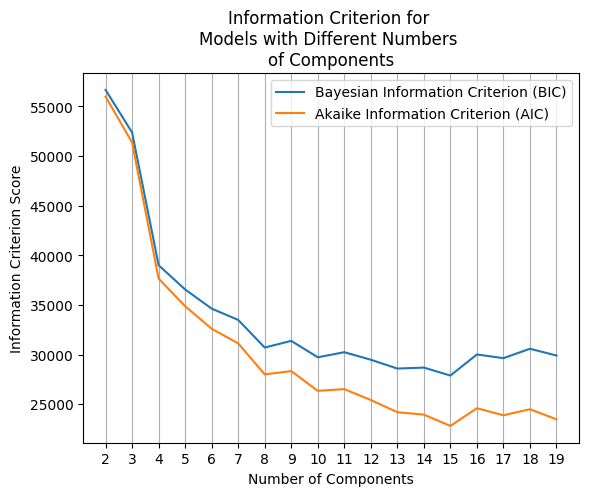

In [29]:
figure = plt.figure()
axes = figure.add_subplot(111)
axes.set_xticks(ticks = range(len(range_components_trying)), labels = range_components_trying)
axes.grid(visible=True, axis='x')
axes.set_ylabel('Information Criterion Score')
axes.set_xlabel('Number of Components')
axes.set_title('Information Criterion for \nModels with Different Numbers \nof Components')

axes.plot(bic)
axes.plot(aic)
axes.legend(['Bayesian Information Criterion (BIC)', 'Akaike Information Criterion (AIC)'])

if SAVE_FIGURES:
    figure.savefig(join('outputs', 'latent_profile_analysis.png'))
if PRINT_OUTPUT:
    figure.show()
else:
    plt.close(figure)

The graphs seem to indicate that a model with <i>8-10 components</i> would be both relatively well-performing and still parsimonious.

In [48]:
NUM_CLUSTERS = 10 # <-- Choose here.

# Fitting and Assessing Models

In [49]:
model = StepMix(
    n_components = NUM_CLUSTERS,
    measurement = 'continuous',
    init_params = 'random',
    random_state = SEED,
    progress_bar = 1 if PRINT_OUTPUT else 0
).fit(
    X=onet_skills.values
)

assignments = model.predict(onet_skills.values)
assignments_probabilities = np.apply_along_axis(
    max, 
    arr=model.predict_proba(onet_skills.values), 
    axis=1
)
onet_skills['Cluster'] = assignments
onet_skills['Cluster Probability'] = assignments_probabilities

Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:00<00:00,  1.54it/s, max_LL=-7.22e+3, max_avg_LL=-8.27]


## Displaying Cluster Assignments and Describing Clusters

In [50]:
if SAVE_FIGURES:
    excel_writer = pd.ExcelWriter(join('outputs', f'latent_profile_analysis_{NUM_CLUSTERS}_clusters.xlsx'))

Displaying Cluster Assignments

In [51]:
assignments = onet_skills.reset_index().set_index('Cluster')[['Title', 'O*NET-SOC Code']].sort_index()

if PRINT_OUTPUT:
    display(assignments)
if SAVE_FIGURES:
    assignments.to_excel(excel_writer, 'Cluster Assignments')

,Title,O*NET-SOC Code
Cluster,,
0,Hearing Aid Specialists,29-2092.00
0,Surveyors,17-1022.00
0,Cartographers and Photogrammetrists,17-1021.00
0,Bioinformatics Technicians,15-2099.01
0,Chefs and Head Cooks,35-1011.00
...,...,...
9,Packaging and Filling Machine Operators and Te...,51-9111.00
9,"Furnace, Kiln, Oven, Drier, and Kettle Operato...",51-9051.00
9,"Extruding, Forming, Pressing, and Compacting M...",51-9041.00


Displaying Cluster Skill Means

In [52]:
occupation_clusters_groupby = onet_skills.drop(columns='Cluster Probability').groupby(
    by=['Cluster']
)

mean = occupation_clusters_groupby.mean()
median = occupation_clusters_groupby.median()
std = occupation_clusters_groupby.std()
if PRINT_OUTPUT:
    display(mean)
    display(median)
    display(std)
if SAVE_FIGURES:
    mean.to_excel(excel_writer, 'Cluster Means')
    median.to_excel(excel_writer, 'Cluster Medians')
    std.to_excel(excel_writer, 'Cluster Standard Deviations')

,Active Learning,Active Listening,Complex Problem Solving,Coordination,Critical Thinking,Equipment Maintenance,Equipment Selection,Installation,Instructing,Judgment and Decision Making,...,Science,Service Orientation,Social Perceptiveness,Speaking,Systems Analysis,Systems Evaluation,Technology Design,Time Management,Troubleshooting,Writing
Cluster,,,,,,,,,,,,,,,,,,,,,
0,3.271136,3.712614,3.232045,3.232955,3.720341,1.453636,1.562386,0.233864,3.111477,3.208636,...,2.155909,2.971023,3.165341,3.585682,2.872955,2.836023,1.181591,3.156364,2.141477,3.393182
1,3.860729,4.148178,3.695911,3.502024,4.127976,0.000000,0.166235,0.000000,3.500324,3.805547,...,1.892348,3.310202,3.754211,4.159109,3.265668,3.304980,0.967045,3.439514,0.521336,4.092267
2,3.271905,3.802619,3.088810,3.287619,3.758810,0.225476,0.399286,0.025952,3.032857,3.192857,...,0.755000,3.236905,3.421429,3.818333,2.704048,2.765476,0.878095,3.096190,0.931190,3.450238
3,2.664510,3.066275,2.621176,2.833333,3.064902,0.882941,1.023922,0.089412,2.363137,2.664706,...,0.640196,2.691373,2.751765,2.944314,1.898039,1.901569,0.642941,2.635490,1.501569,2.693922
4,4.109485,4.082887,4.006701,3.466907,4.248763,0.978557,1.514330,0.358247,3.580103,3.982474,...,3.346495,3.076392,3.388660,4.106289,3.606495,3.629588,2.131443,3.454227,2.037629,4.136804
5,2.788923,3.460462,2.666308,2.901231,3.287385,0.000000,0.073692,0.000000,2.438769,2.743692,...,0.250462,3.074923,3.046154,3.310615,1.986000,1.890769,0.479231,2.804000,0.454462,3.074308
6,3.019873,3.163418,3.079367,3.034051,3.407722,3.174430,2.668987,1.892658,2.815190,3.037468,...,1.618354,2.544304,2.736962,3.034051,2.714177,2.667722,1.328861,2.974557,3.335570,2.920253
7,2.040769,2.769487,2.043333,2.480513,2.570256,0.307179,0.210513,0.000000,1.746410,2.181795,...,0.092308,2.466154,2.522564,2.563333,1.256410,1.175897,0.284872,2.262051,0.842821,2.233590
8,2.494719,2.901910,2.704270,2.782247,2.973596,2.649775,2.214831,0.876629,2.366517,2.697865,...,0.797528,2.178315,2.426404,2.727416,2.065506,2.003483,0.877528,2.726854,2.735056,2.464831


,Active Learning,Active Listening,Complex Problem Solving,Coordination,Critical Thinking,Equipment Maintenance,Equipment Selection,Installation,Instructing,Judgment and Decision Making,...,Science,Service Orientation,Social Perceptiveness,Speaking,Systems Analysis,Systems Evaluation,Technology Design,Time Management,Troubleshooting,Writing
Cluster,,,,,,,,,,,,,,,,,,,,,
0,3.12,3.75,3.185,3.12,3.75,1.41,1.62,0.000,3.12,3.12,...,2.38,3.00,3.12,3.62,3.00,2.88,1.12,3.12,2.12,3.38
1,3.88,4.12,3.750,3.50,4.12,0.00,0.00,0.000,3.38,3.88,...,1.75,3.12,3.75,4.12,3.12,3.25,0.88,3.38,0.38,4.00
2,3.25,3.88,3.000,3.12,3.75,0.12,0.38,0.000,3.00,3.12,...,0.38,3.25,3.38,3.88,2.75,2.75,0.75,3.00,1.12,3.38
3,2.75,3.00,2.620,3.00,3.12,0.88,1.00,0.000,2.38,2.75,...,0.38,2.88,2.88,3.00,2.00,2.00,0.62,2.75,1.62,2.75
4,4.00,4.00,4.000,3.50,4.12,0.75,1.50,0.000,3.50,4.00,...,3.50,3.00,3.25,4.00,3.62,3.69,2.00,3.50,2.00,4.12
5,2.88,3.50,2.750,3.00,3.25,0.00,0.00,0.000,2.38,2.88,...,0.00,3.00,3.00,3.25,2.00,2.00,0.50,2.88,0.38,3.00
6,3.00,3.12,3.000,3.00,3.38,3.00,2.62,2.120,2.88,3.00,...,1.50,2.62,2.75,3.00,2.75,2.75,1.38,3.00,3.25,3.00
7,2.12,2.75,2.120,2.50,2.62,0.12,0.12,0.000,2.00,2.12,...,0.00,2.62,2.62,2.62,1.25,1.12,0.25,2.25,0.88,2.12
8,2.50,3.00,2.750,2.88,3.00,2.75,2.12,0.620,2.38,2.75,...,0.75,2.12,2.50,2.75,2.12,2.00,0.88,2.75,2.88,2.50


,Active Learning,Active Listening,Complex Problem Solving,Coordination,Critical Thinking,Equipment Maintenance,Equipment Selection,Installation,Instructing,Judgment and Decision Making,...,Science,Service Orientation,Social Perceptiveness,Speaking,Systems Analysis,Systems Evaluation,Technology Design,Time Management,Troubleshooting,Writing
Cluster,,,,,,,,,,,,,,,,,,,,,
0,0.301202,0.272124,0.272309,0.323526,0.257599,0.870051,0.735005,0.436531,0.248089,0.237081,...,1.133007,0.315981,0.299209,0.297564,0.340501,0.388441,0.596075,0.287767,0.572463,0.323890
1,0.429377,0.336949,0.459852,0.429675,0.332690,0.000000,0.277678,0.000000,0.561542,0.419789,...,1.461980,0.499133,0.557470,0.351422,0.462084,0.484868,0.457743,0.374759,0.573443,0.476702
2,0.336577,0.267928,0.259241,0.351754,0.223260,0.274752,0.348743,0.057384,0.437411,0.291299,...,0.785867,0.389962,0.413236,0.267681,0.394944,0.490909,0.322235,0.311448,0.612393,0.338904
3,0.366204,0.251077,0.260865,0.363800,0.254561,0.632194,0.618689,0.241366,0.563899,0.288016,...,0.676959,0.455803,0.305403,0.257412,0.313394,0.323428,0.358738,0.295170,0.473862,0.303875
4,0.409531,0.226559,0.290949,0.336546,0.304386,1.000575,0.988504,0.713991,0.423169,0.294396,...,1.163512,0.415978,0.401782,0.293851,0.375489,0.400231,1.037670,0.350238,0.971175,0.395341
5,0.386810,0.398522,0.314377,0.335808,0.325150,0.000000,0.185545,0.000000,0.410782,0.357559,...,0.363273,0.462585,0.321800,0.354184,0.342864,0.369570,0.327802,0.288681,0.500915,0.550653
6,0.201294,0.269505,0.227074,0.276162,0.265899,0.498119,0.364785,1.219806,0.328789,0.183795,...,0.817662,0.364082,0.230464,0.181931,0.333515,0.339656,0.564683,0.178525,0.453682,0.190781
7,0.390259,0.422069,0.231054,0.337833,0.347612,0.383851,0.264614,0.000000,0.655429,0.257956,...,0.179890,0.545940,0.398931,0.420810,0.408466,0.410216,0.302610,0.297571,0.535856,0.554391
8,0.295451,0.135075,0.240779,0.352452,0.136500,0.525009,0.340478,0.794279,0.320447,0.200349,...,0.588792,0.357813,0.273426,0.225517,0.328149,0.272472,0.430977,0.231878,0.431578,0.288791


Displaying Cluster Representatives

In [53]:
top_k_highest_prob_occupations_each_cluster = onet_skills \
    .sort_values(
        by=['Cluster', 'Cluster Probability'],
        ascending=[True, False]
    ) \
    .groupby(
        by=['Cluster']
    ) \
    .nth[0:10] \
    .reset_index() \
    .set_index(['Cluster', 'O*NET-SOC Code', 'Title'])

if PRINT_OUTPUT:
    display(top_k_highest_prob_occupations_each_cluster)
if SAVE_FIGURES:
    top_k_highest_prob_occupations_each_cluster.to_excel(excel_writer, 'Cluster Representatives')

Active Learning  \
Cluster O*NET-SOC Code Title                                                                 
0       17-3029.01     Non-Destructive Testing Specialists                            3.62   
        19-4071.00     Forest and Conservation Technicians                            3.00   
        19-4099.01     Quality Control Analysts                                       3.12   
        25-4013.00     Museum Technicians and Conservators                            3.12   
        29-1124.00     Radiation Therapists                                           3.00   
...                                                                                    ...   
9       47-2043.00     Floor Sanders and Finishers                                    2.25   
        47-2051.00     Cement Masons and Concrete Finishers                           1.75   
        47-2053.00     Terrazzo Workers and Finishers                                 2.12   
        47-2061.00     Construction Laborers                                          2.12   
        47-2071.00     Paving, Surfacing, and Tamping Equipment Operators             2.12   

                                                                           Active Listening  \
Cluster O*NET-SOC Code Title                                                                  
0       17-3029.01     Non-Destructive Testing Specialists                             3.38   
        19-4071.00     Forest and Conservation Technicians                             3.75   
        19-4099.01     Quality Control Analysts                                        3.75   
        25-4013.00     Museum Technicians and Conservators                             3.88   
        29-1124.00     Radiation Therapists                                            3.88   
...                                                                                     ...   
9       47-2043.00     Floor Sanders and Finishers                                     2.75   
        47-2051.00     Cement Masons and Concrete Finishers                            2.25   
        47-2053.00     Terrazzo Workers and Finishers                                  2.00   
        47-2061.00     Construction Laborers                                           3.00   
        47-2071.00     Paving, Surfacing, and Tamping Equipment Operators              2.75   

                                                                           Complex Problem Solving  \
Cluster O*NET-SOC Code Title                                                                         
0       17-3029.01     Non-Destructive Testing Specialists                                    3.00   
        19-4071.00     Forest and Conservation Technicians                                    3.00   
        19-4099.01     Quality Control Analysts                                               3.25   
        25-4013.00     Museum Technicians and Conservators                                    3.00   
        29-1124.00     Radiation Therapists                                                   3.00   
...                                                                                            ...   
9       47-2043.00     Floor Sanders and Finishers                                            2.50   
        47-2051.00     Cement Masons and Concrete Finishers                                   2.62   
        47-2053.00     Terrazzo Workers and Finishers                                         2.38   
        47-2061.00     Construction Laborers                                                  2.62   
        47-2071.00     Paving, Surfacing, and Tamping Equipment Operators                     2.50   

                                                                           Coordination  \
Cluster O*NET-SOC Code Title                                                              
0       17-3029.01     Non-Destructive Testing Specialists                         2.88   
        19-4071.

In [54]:
if SAVE_FIGURES:
    excel_writer.close()

# Training Decision Tree on Assigned Clusters as an Attempted Explanation

In [55]:
decision_tree = DecisionTreeClassifier(
    criterion='gini',
    splitter='best',
    max_depth=None,
    random_state=SEED
).fit(
    X = onet_skills.drop(columns='Cluster'),
    y= onet_skills['Cluster']
)

/var/folders/nc/4202mlvd4hg61x79bmx7rfg00000gn/T/ipykernel_13513/2780554206.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


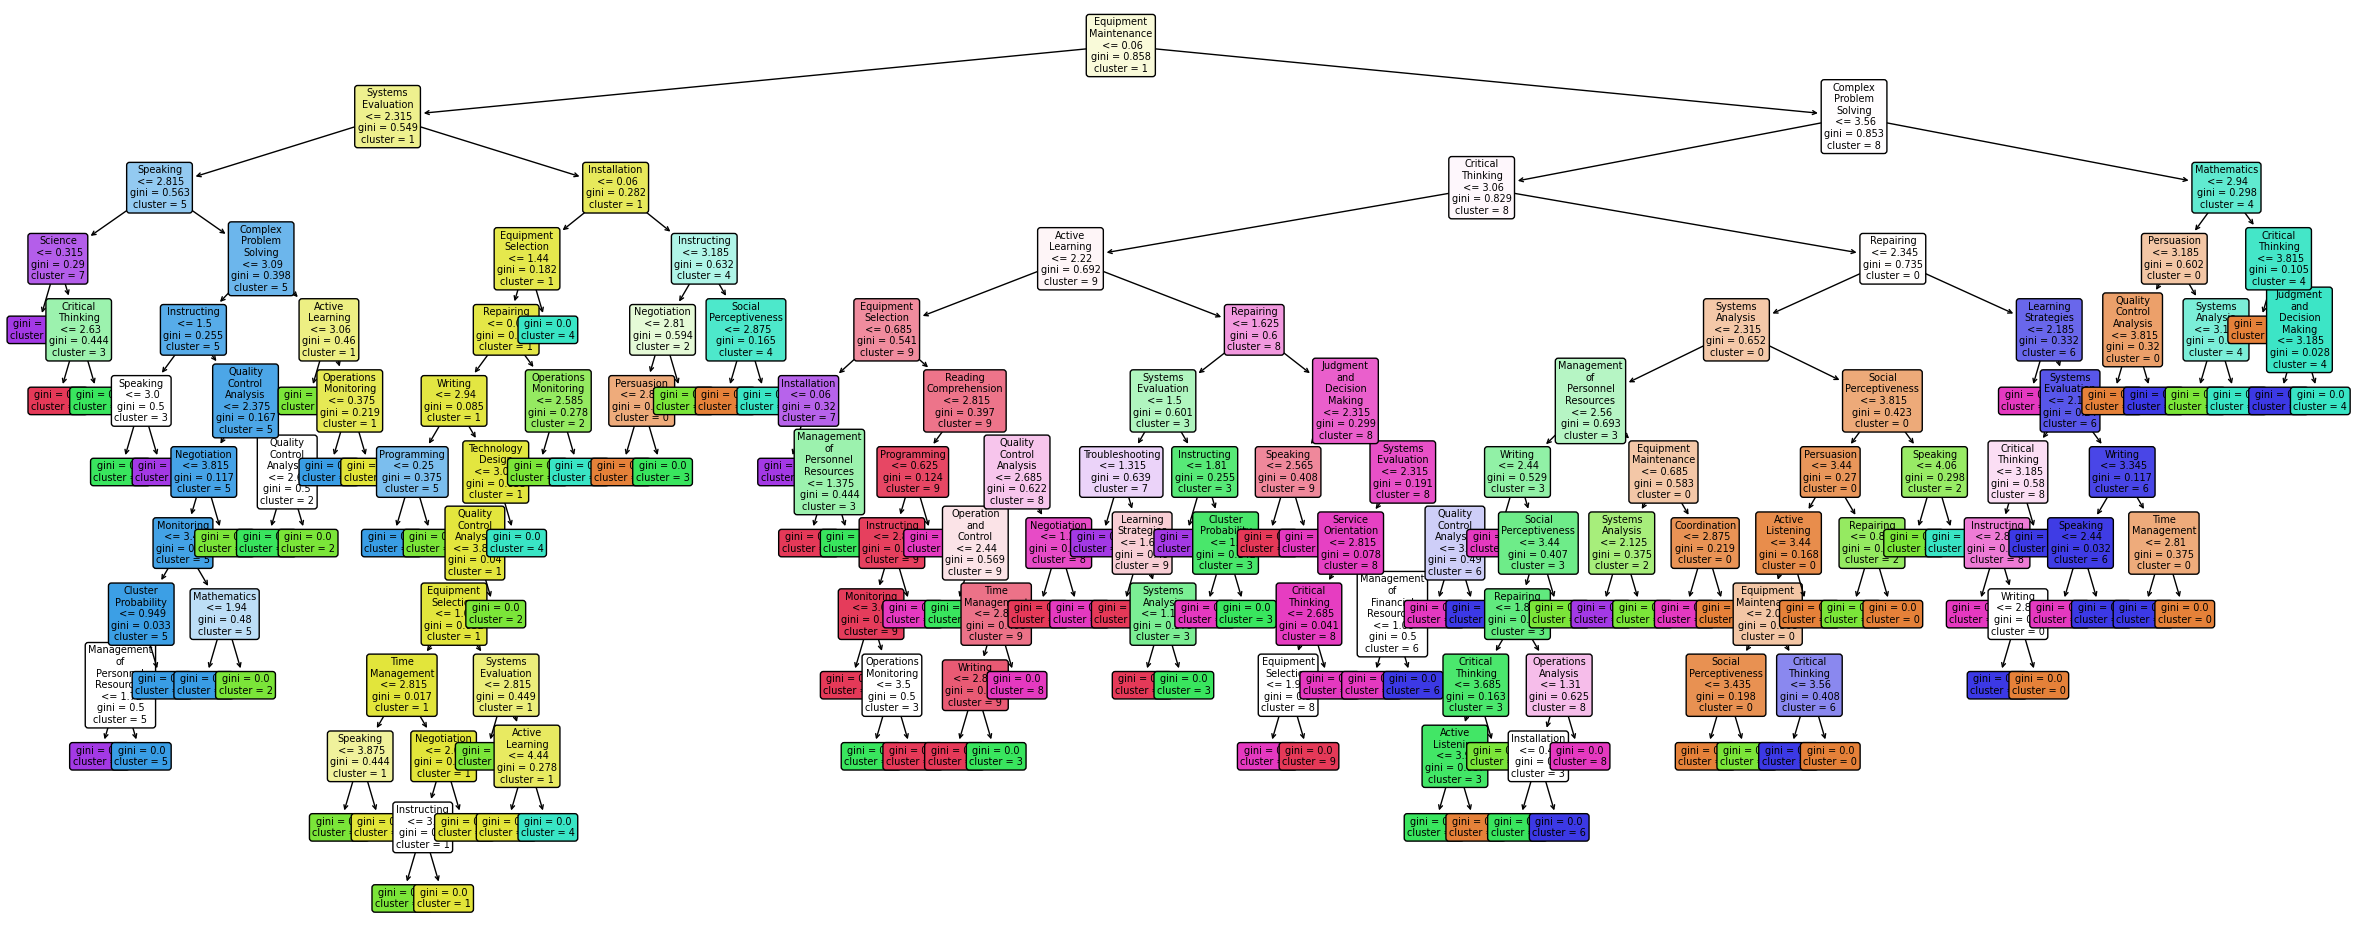

In [56]:
figure = plt.figure(figsize=(30, 12));
axes = figure.add_subplot(111);

plot_tree(
    decision_tree, 
    feature_names=onet_skills.drop(columns='Cluster').columns,
    impurity=True,
    fontsize=7, 
    rounded=True, 
    filled=True, 
    ax=axes
);

format_decision_tree_plot(axes)

if SAVE_FIGURES:
    figure.savefig(join('outputs', f'latent_profile_analysis_decision_tree_{NUM_CLUSTERS}.png'))
if PRINT_OUTPUT:
    figure.show()
else:
    plt.close(figure)